In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [3]:
from ase.filters import FrechetCellFilter
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor
# from orb_models.forcefield import pretrained
# from orb_models.forcefield.calculator import ORBCalculator
from fairchem.core import pretrained_mlip, FAIRChemCalculator
# from mace.calculators import mace_mp # need e3nn 0.4.4
# from sevenn.calculator import SevenNetCalculator # need e3nn 0.5.0 later change numpy to 1.26.4
# from mattersim.forcefield import MatterSimCalculator

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [4]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [5]:
MODEL = "orb" # "orb" or "uma" or "mace" or "seven" or "mattersim"

In [6]:
orb_ff = pretrained.orb_v3_conservative_inf_omat(device="cuda",precision="float32-high")   # or "float32-highest" / "float64
orb_calc = ORBCalculator(orb_ff, device="cuda")

# uma_ff = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
# uma_calc = FAIRChemCalculator(uma_ff, task_name="omat")

# # mace_calc = mace_mp(model="MACE-matpes-r2scan-omat-ft.model", dispersion=False, device='cuda')

# seven_calc = SevenNetCalculator('7net-mf-ompa', modal='omat24')

# mattersim_calc = MatterSimCalculator(device="cuda")

MODELS = {
    "orb":orb_calc,
    # "uma":uma_calc,
    # "mace":mace_calc,
    # "seven":seven_calc,
    # "mattersim":mattersim_calc,
}

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/orb_models/utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")


In [7]:
# Function used to relax initial primitive cell and for competing phase calculation, full relaxation using FrechetCellFilter
def relax_structure(structure):
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(FrechetCellFilter(atoms)) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    relaxed_structure = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return relaxed_structure, energy 
    

In [8]:
# Function that relaxes defect and pristine supercells, ensuring a fixed lattice by no FrechetCellFilter
def relax_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    relaxed_structure = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return relaxed_structure, energy 

## Relaxation of Primitive Al Cells

In [9]:
matching_pairs = loadfn('../../data/cr_above_hull/matching_AlCr_ox.json')

In [10]:
relaxed_Al_prim = {}
for name, val in matching_pairs.items():
    structure, energy = relax_structure(val['structure'])
    relaxed_Al_prim[name] = {
        'formula': val['formula'],
        'energy': energy,
        'structure': structure
    }

W0804 19:03:43.797000 11383 site-packages/torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
W0804 19:03:44.215000 11383 site-packages/torch/_dynamo/convert_frame.py:1233] WON'T CONVERT forward /home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/orb_models/forcefield/gns.py line 421 
W0804 19:03:44.215000 11383 site-packages/torch/_dynamo/convert_frame.py:1233] due to: 
W0804 19:03:44.215000 11383 site-packages/torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0804 19:03:44.215000 11383 site-packages/torch/_dynamo/convert_frame.py:1233]   File "/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0804 19:03:44.215000 11383 site-packages/torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0804 19:03:44.215000 11383 site-packages/torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0804 19:03:44.215000 11383 s

       Step     Time          Energy          fmax
LBFGS:    0 19:03:51      -51.323738        0.385983
LBFGS:    1 19:03:51      -51.329597        0.359416
LBFGS:    2 19:03:52      -51.355026        0.273039
LBFGS:    3 19:03:53      -51.360706        0.247854
LBFGS:    4 19:03:53      -51.366169        0.085528
LBFGS:    5 19:03:53      -51.366745        0.077684
LBFGS:    6 19:03:53      -51.366936        0.069090
LBFGS:    7 19:03:54      -51.367218        0.053141
LBFGS:    8 19:03:54      -51.367691        0.056961
LBFGS:    9 19:03:54      -51.368107        0.044428
LBFGS:   10 19:03:54      -51.368259        0.015662
LBFGS:   11 19:03:54      -51.368279        0.002476
       Step     Time          Energy          fmax
LBFGS:    0 19:03:54    -1015.831238        0.214530
LBFGS:    1 19:03:55    -1015.851440        0.132380
LBFGS:    2 19:03:56    -1015.867920        0.133474
LBFGS:    3 19:03:56    -1015.953552        0.178574
LBFGS:    4 19:03:56    -1015.989868        0.1738

In [11]:
dumpfn(relaxed_Al_prim, f'../../data/cr_above_hull/{MODEL}_relaxed_Al_prim.json')

## Defect Creation and Relaxation

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [12]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions
from pymatgen.entries.computed_entries import ComputedEntry
from doped.core import DefectEntry
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility
from pymatgen.core import Element

In [13]:
supercell_size = 10

In [14]:
MP_U_VALUES = {
    "Co": 3.32,
    "Cr": 3.7,
    "Fe": 5.3,
    "Mn": 3.98,
    "Mo": 4.38,
    "Ni": 6.2,
    "V": 3.25,
    "W": 6.2,
}
from pymatgen.core import Species

def add_parameters(entry):
    elements = entry.composition.elements
    elements = [el.element if isinstance(el, Species) else el for el in elements]
    parameters = {}
    if any([Element(el) in elements for el in MP_U_VALUES]):
        parameters["run_type"] = "GGA+U"
        parameters["hubbards"] = {el.name: MP_U_VALUES.get(el.symbol, 0.0) for el in elements}
        parameters["is_hubbard"] = True
    else:
        parameters["run_type"] = "GGA"
        parameters["hubbards"] = None
        parameters["is_hubbard"] = False
    entry.parameters = parameters
    return entry

In [15]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False, supercell_gen_kwargs={'min_image_distance':supercell_size} ) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}'
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    distortions = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, distortions.distortion_metadata = distortions.apply_distortions()
    unperturbed_structures = {}
    defect_distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        defect_distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return unperturbed_structures, defect_distortions, defect_gen.bulk_supercell

In [16]:
def make_entry(structure, energy, material_id):
    new_entry = ComputedEntry(
        structure.composition,
        energy, 
        data={'material_id':material_id}
    )
    new_entry.structure = structure
    new_entry = add_parameters(new_entry)
    compat = MaterialsProject2020Compatibility(check_potcar=False, check_potcar_hash=False)
    compat.process_entry(new_entry, on_error="warn")
    return new_entry

In [17]:
def get_energy(unperturbed_structures, distortions, supercell, material_id):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relax_defect(supercell)
    new_entries_sup = make_entry(supercell_struct, supercell_e, material_id)
    data['supercell'] = {
        'structure': new_entries_sup.structure,
        'energy': new_entries_sup.energy
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relax_defect(unperturbed_structure)
        new_entries_unp = make_entry(unperturbed_structure1, unp_energy, material_id)
        data[site]['unperturbed'] = {
        'structure':new_entries_unp.structure,
        'energy': new_entries_unp.energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relax_defect(structure)
            new_entries_def = make_entry(structure1, energy, material_id)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': new_entries_def.structure,
                'energy': new_entries_def.energy,
                'distortion_amount': distortion_amount,
                'delta_e': new_entries_def.energy - data[site]['unperturbed']['energy']
            }
        
    return dict(data)

In [19]:
Al_prim = loadfn(f'../../data/cr_above_hull/{MODEL}_relaxed_Al_prim.json')

In [20]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(Al_prim[key]['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell, key) # add in host supercell relaxation
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:10,   1.42it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  2a
v_Cu         [+1,0,-1]          [0.333,0.667,0.250]  2c
v_O          [+2,+1,0,-1]       [0.333,0.667,0.085]  4f

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cu            [+2,+1,0]           [0.333,0.667,0.250]  2c
Al_O             [+5,+4,+3,+2,+1,0]  [0.333,0.667,0.085]  4f
Cu_Al            [0,-1,-2]           [0.000,0.000,0.000]  2a
Cu_O             [+4,+3,+2,+1,0]     [0.333,0.667,0.085]  4f
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.000]  2a
O_Cu             [0,-1,-2,-3]        [0.333,0.667,0.250]  2c
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.000]  2a
Cr_Cu            [+5,+4,+3,+2,+1,0]  [0.333,0.667,0.250]  2c
Cr_O             [+5,+4,+3,+2,+1,0]  [0.333,0.667,0.085]  4f

The number in the Wycko

Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   9.73it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 19:06:08     -667.787598        0.002460
       Step     Time          Energy          fmax
LBFGS:    0 19:06:08     -668.511353        1.642988
LBFGS:    1 19:06:09     -668.696472        1.007853
LBFGS:    2 19:06:09     -668.837341        0.229519
LBFGS:    3 19:06:09     -668.853333        0.165143
LBFGS:    4 19:06:10     -668.861938        0.082492
LBFGS:    5 19:06:10     -668.865295        0.064606
LBFGS:    6 19:06:11     -668.867310        0.062991
LBFGS:    7 19:06:11     -668.868286        0.047028
LBFGS:    8 19:06:12     -668.869019        0.031617
LBFGS:    9 19:06:12     -668.869446        0.026479
LBFGS:   10 19:06:12     -668.869873        0.023350
LBFGS:   11 19:06:13     -668.870117        0.019443
LBFGS:   12 19:06:13     -668.870361        0.020910
LBFGS:   13 19:06:14     

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al25Cr(CuO2)26). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:06:15     -595.445007       21.857656
LBFGS:    1 19:06:15     -631.184448        8.483608
LBFGS:    2 19:06:16     -652.118469        3.904003
LBFGS:    3 19:06:16     -660.004089        2.915182
LBFGS:    4 19:06:16     -663.041260        2.449082
LBFGS:    5 19:06:17     -665.415527        1.973682
LBFGS:    6 19:06:17     -666.603516        1.388330
LBFGS:    7 19:06:18     -667.386230        1.098797
LBFGS:    8 19:06:18     -667.865295        0.753960
LBFGS:    9 19:06:19     -668.222290        0.549936
LBFGS:   10 19:06:19     -668.408997        0.444199
LBFGS:   11 19:06:19     -668.539917        0.434281
LBFGS:   12 19:06:20     -668.637207        0.374873
LBFGS:   13 19:06:20     -668.707642        0.388630
LBFGS:   14 19:06:21     -668.753906        0.264070
LBFGS:   15 19:06:21     -668.784546        0.194189
LBFGS:   16 19:06:22     -668.803894        0.163255
LBFGS:   17 19:06:22     -668.816528        0.13

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [03:03,   1.84s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Cs_C1                   [+1,0,-1]                 [0.000,0.000,0.000]  4a
v_Cs_Ci                   [+1,0,-1]                 [0.000,0.000,0.000]  4a
v_Al_Ci_O1.90H2.58H2.65a  [+1,0,-1,-2,-3]           [0.500,0.500,0.500]  4b
v_Al_Ci_O1.90H2.58H2.65b  [+1,0,-1,-2,-3]           [0.500,0.500,0.500]  4b
v_H_C1_O0.99H1.57O1.76a   [+1,0,-1]                 [0.225,0.492,0.260]  24d
v_H_C1_O0.99H1.57O1.76b   [+1,0,-1]                 [0.225,0.492,0.260]  24d
v_H_C1_O0.99H1.57O1.76c   [+1,0,-1]                 [0.225,0.492,0.261]  24d
v_H_C1_O0.99H1.57O1.76d   [+1,0,-1]                 [0.225,0.492,0.260]  24d
v_H_C1_O0.99H1.57O1.76e   [+1,0,-1]                 [0.225,0.492,0.260]  24d
v_H_C1_O0.99H1.57O1.76f   [+1,0,-1]                 [0.225,0.492,0.260]  24d
v_H_C1_O0.99H1.57O1.76g   [+1,0,-1]                 [0.225,0.492,0.260

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al_Ci_O1.90H2.58H2.65a
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci_O1.90H2.58H2.65a in charge state: 0. Number of distorted neighbours: 0


distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.9896635447700064 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually
Generating distorted defect structures...50.0%|██████████████████████████                          | [00:13,  13.82s/it]


Defect: Cr_Al_Ci_O1.90H2.58H2.65b
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci_O1.90H2.58H2.65b in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:27,  13.85s/it]


       Step     Time          Energy          fmax
LBFGS:    0 19:10:08    -1016.138611        0.006427


compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (CsAlH24(SO10)2). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:10:09    -1016.546509        1.636583
LBFGS:    1 19:10:09    -1016.692871        0.521176
LBFGS:    2 19:10:10    -1016.774353        0.536492
LBFGS:    3 19:10:11    -1016.864319        0.359636
LBFGS:    4 19:10:11    -1016.895996        0.276708
LBFGS:    5 19:10:12    -1016.922546        0.265034
LBFGS:    6 19:10:13    -1016.946228        0.251955
LBFGS:    7 19:10:13    -1016.961914        0.171466
LBFGS:    8 19:10:14    -1016.968201        0.074270
LBFGS:    9 19:10:15    -1016.970154        0.066438
LBFGS:   10 19:10:15    -1016.972168        0.073526
LBFGS:   11 19:10:16    -1016.975220        0.097460
LBFGS:   12 19:10:17    -1016.977600        0.073310
LBFGS:   13 19:10:17    -1016.979065        0.045661
LBFGS:   14 19:10:18    -1016.979980        0.041741
LBFGS:   15 19:10:19    -1016.981506        0.071529
LBFGS:   16 19:10:19    -1016.983154        0.085725
LBFGS:   17 19:10:20    -1016.984619        0.05

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Cs4Al3CrH96(SO10)8). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:10:32     -910.636719       14.223276
LBFGS:    1 19:10:33     -964.243652        6.732552
LBFGS:    2 19:10:34     -999.652649        6.721339
LBFGS:    3 19:10:34    -1007.144531        3.513315
LBFGS:    4 19:10:35    -1010.906494        2.122299
LBFGS:    5 19:10:36    -1013.192505        1.898527
LBFGS:    6 19:10:37    -1014.992249        2.038100
LBFGS:    7 19:10:37    -1015.400391        0.623651
LBFGS:    8 19:10:38    -1015.762390        0.557072
LBFGS:    9 19:10:39    -1016.022644        1.047683
LBFGS:   10 19:10:39    -1016.318665        0.917608
LBFGS:   11 19:10:40    -1016.471985        0.491077
LBFGS:   12 19:10:41    -1016.564575        0.454952
LBFGS:   13 19:10:41    -1016.639160        0.324764
LBFGS:   14 19:10:42    -1016.704956        0.308798
LBFGS:   15 19:10:43    -1016.744934        0.297887
LBFGS:   16 19:10:43    -1016.786011        0.256641
LBFGS:   17 19:10:44    -1016.820496        0.22

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Cs4Al3CrH96(SO10)8). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:11:30    -1016.546509        1.638204
LBFGS:    1 19:11:30    -1016.693115        0.522064
LBFGS:    2 19:11:31    -1016.774597        0.536316
LBFGS:    3 19:11:32    -1016.864685        0.359106
LBFGS:    4 19:11:32    -1016.896423        0.276497
LBFGS:    5 19:11:33    -1016.922913        0.265311
LBFGS:    6 19:11:34    -1016.946533        0.252093
LBFGS:    7 19:11:34    -1016.962219        0.171185
LBFGS:    8 19:11:35    -1016.968567        0.074326
LBFGS:    9 19:11:36    -1016.970520        0.066572
LBFGS:   10 19:11:36    -1016.972534        0.073279
LBFGS:   11 19:11:37    -1016.975647        0.097114
LBFGS:   12 19:11:38    -1016.978027        0.072982
LBFGS:   13 19:11:38    -1016.979309        0.045632
LBFGS:   14 19:11:39    -1016.980408        0.041706
LBFGS:   15 19:11:40    -1016.981750        0.071326
LBFGS:   16 19:11:40    -1016.983459        0.085472
LBFGS:   17 19:11:41    -1016.985107        0.05

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Cs4Al3CrH96(SO10)8). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:11:54     -911.060059       13.812064
LBFGS:    1 19:11:54     -964.860413        6.757038
LBFGS:    2 19:11:55    -1000.185852        6.947081
LBFGS:    3 19:11:56    -1007.604431        2.883524
LBFGS:    4 19:11:56    -1011.089294        2.006919
LBFGS:    5 19:11:57    -1013.447388        1.851764
LBFGS:    6 19:11:58    -1015.115051        1.375945
LBFGS:    7 19:11:58    -1015.459961        0.773675
LBFGS:    8 19:11:59    -1015.791870        0.676752
LBFGS:    9 19:12:00    -1016.083923        0.887379
LBFGS:   10 19:12:00    -1016.345764        0.719766
LBFGS:   11 19:12:01    -1016.505249        0.469264
LBFGS:   12 19:12:02    -1016.595154        0.300001
LBFGS:   13 19:12:02    -1016.673157        0.313728
LBFGS:   14 19:12:03    -1016.725525        0.264424
LBFGS:   15 19:12:04    -1016.766418        0.303739
LBFGS:   16 19:12:04    -1016.803955        0.233836
LBFGS:   17 19:12:05    -1016.835144        0.20

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Cs4Al3CrH96(SO10)8). Assigning anion correction to only the most electronegative atom.
Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:41,   2.43it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_Fe         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_O          [+2,+1,0,-1]       [0.391,0.391,0.391]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
Fe_Al            [+1,0,-1,-2]        [0.625,0.625,0.625]  16d
Fe_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
O_Fe             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_Fe            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e

The number in t

Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   5.97it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 19:13:27     -610.030518        0.004436
       Step     Time          Energy          fmax
LBFGS:    0 19:13:27     -610.891296        1.551492
LBFGS:    1 19:13:28     -611.058777        1.002188
LBFGS:    2 19:13:28     -611.209900        0.262932
LBFGS:    3 19:13:28     -611.230774        0.209139
LBFGS:    4 19:13:29     -611.248474        0.205342
LBFGS:    5 19:13:29     -611.256714        0.178538
LBFGS:    6 19:13:30     -611.262207        0.119620
LBFGS:    7 19:13:30     -611.265381        0.137922
LBFGS:    8 19:13:30     -611.268311        0.130680
LBFGS:    9 19:13:31     -611.270935        0.093113
LBFGS:   10 19:13:31     -611.272827        0.060527
LBFGS:   11 19:13:31     -611.273987        0.033411
LBFGS:   12 19:13:32     -611.274536        0.035124
LBFGS:   13 19:13:32     

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al23Cr(FeO4)12). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:13:34     -560.918518       13.312381
LBFGS:    1 19:13:34     -585.423706        6.218417
LBFGS:    2 19:13:35     -598.442139        3.009621
LBFGS:    3 19:13:35     -603.955322        2.380370
LBFGS:    4 19:13:35     -606.054321        1.987482
LBFGS:    5 19:13:36     -608.399231        1.501804
LBFGS:    6 19:13:36     -609.439697        1.368504
LBFGS:    7 19:13:36     -610.252075        0.953217
LBFGS:    8 19:13:37     -610.663574        0.921440
LBFGS:    9 19:13:37     -610.952026        0.658275
LBFGS:   10 19:13:37     -611.071655        0.458480
LBFGS:   11 19:13:38     -611.144714        0.315368
LBFGS:   12 19:13:38     -611.187805        0.207998
LBFGS:   13 19:13:39     -611.213623        0.193818
LBFGS:   14 19:13:39     -611.230347        0.163366
LBFGS:   15 19:13:39     -611.242065        0.130843
LBFGS:   16 19:13:40     -611.249756        0.102746
LBFGS:   17 19:13:40     -611.255249        0.08

In [21]:
for key, val in Al_prim.items():
    data[key]['formula'] = val['formula']

In [22]:
for key,val in data.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [23]:
dumpfn(data, f'../../data/cr_above_hull/{MODEL}_corrected_doped_defect_energies_{supercell_size}A.json')

In [24]:
data_load = loadfn(f'../../data/cr_above_hull/{MODEL}_corrected_doped_defect_energies_{supercell_size}A.json')

In [25]:
compounds = []
delta_e = []
for key, val in data_load.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data_load[key]['formula'])

In [26]:
import matplotlib.pyplot as plt

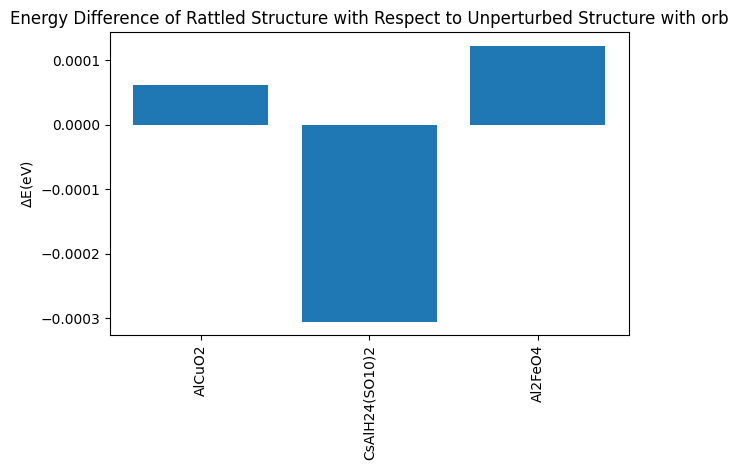

In [28]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title(f"Energy Difference of Rattled Structure with Respect to Unperturbed Structure with {MODEL}")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"../../figures/cr_above_hull/{MODEL}_corrected_energy_difference_plot_{supercell_size}A.png", dpi=300, bbox_inches='tight')

plt.show()